<a href="https://colab.research.google.com/github/yashpatel5400/CurveTorch/blob/main/tutorials/basic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
CurveTorch can be used interchangeably with any other PyTorch optimizer. The only thing that may be different from most optimizers you usually use is the need to pass in the optimizer function closure. This allows the optimizer to access Hessian information during the update step. We will see an example of how to do this further below. Let's start by importing the usual packages:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt

Let's now continue by importing the CurveSGD package. If you have installed it globally, there is no need to add the `sys.append`:

In [8]:
# hack for importing local library: not necessary if installed globally
import sys
sys.path.append("..")
import curvetorch as curve

## CurveSGD Usage
In this tutorial, we will simply use CurveSGD to optimize a simple function. See the other tutorial to see how to use CurveSGD to optimize neural networks:

In [9]:
def quadratic(tensor):
    x, y = tensor
    a = 1.0
    b = 1.0
    return (x ** 2) / a + (y ** 2) / b

Let's see how to actually use CurveSGD in an optimization loop:

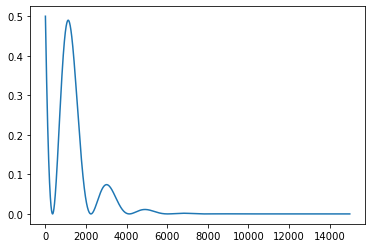

In [14]:
iterations = 15000
initial_state = (0.5, 0.5)
min_loc = (0, 0)

x = torch.Tensor(initial_state).requires_grad_(True)
x_min = torch.Tensor(min_loc)
optimizer = curve.CurveSGD([x], lr=.0015)
fs = []
for _ in range(iterations):
    fs.append(quadratic(x))
    def closure():
        optimizer.zero_grad()
        f = quadratic(x)
        f.backward(retain_graph=True, create_graph=True)
        return f
    optimizer.step(closure)
plt.plot(range(iterations), fs)
plt.show()

As mentioned towards the beginning of the tutorial, we have a chunk of code that is somewhat atypical of standard optimizers: the use of function closures. Generally, optimizers perform updates via: `optimizer.step()`. In this case, however, we have:

```
def closure():
    optimizer.zero_grad()
    f = quadratic(x)
    f.backward(retain_graph=True, create_graph=True)
    return f
optimizer.step(closure)
```

With the reason being that we need the entire closure of the loss to access Hessian information within the optimization step. Other optimizers that require 2nd order information similarly make use of function closures, but they are less common than 1st order methods, which can get away with simply being invoked using `optimizer.step()`. 

And that's it! Notice that there is nothing different about the invocation of CurveSGD for optimization compared to other optimizers in the PyTorch library, with the exception of having to invoke the function closure for Hessian information. For full documentation, see the associated website or Sphinx pages.